# Stellar population models

Meaningless introduction. Smart remark, Douglas Adams reference. Monty Python joke.

Now getting into business. I will noy get into details about how these models were created. Just download the [BC03 models](http://minerva.ufsc.br/~andre/aula-ifs/BC03models.tar.bz2) and the [paper](http://minerva.ufsc.br/~andre/aula-ifs/BC03.pdf), which of course you will never read.

## Reading the data

BC03 models come in ascii tables. There are other tables with metadata, which help organize them (`Base.bc03.*` files, in the STARLIGHT format). Below are some routines to read and store the base data and spectra into a more suitable format. You may write these routines yourself to use your favourite tools and formats, but it is only a technical exercise. The ascii files are very slow to read, do it only once and store the data in FITS files (or whatever format you choose).

In [1]:
import numpy as np

def read_base_ascii(basefile):
    from astropy.table import Table

    dt = np.dtype([('sspfile', '|S60'), ('age_base', '>f8'), ('Z_base', '>f8'),
                   ('Mstars', '>f8'), ('YA_V', '>i4'), ('aFe', '>f8') ])
    bdata = np.loadtxt(basefile, dtype=dt, skiprows=1, usecols=(0,1,2,4,5,6))
    base = Table(bdata)
    
    spec = Table.read(base[0]['sspfile'], format='ascii', names=['l_ssp', 'f_ssp'])
    l_ssp = spec['l_ssp'].data.copy()
    base_spec = np.empty((len(l_ssp), len(base)))
    for i, sspfile in enumerate(base['sspfile']):
        print '%s (%d/%d)' % (sspfile, i, len(base))
        spec = Table.read(sspfile, format='ascii', names=['l_ssp', 'f_ssp'])
        base_spec[:, i] = spec['f_ssp']
    
    return base, l_ssp, base_spec


def save_base_fits(base, l_ssp, base_spec, basefile):
    from astropy.io import fits

    th = fits.TableHDU(base.as_array(), name='base')
    lh = fits.PrimaryHDU(l_ssp)
    lh.name = 'l_ssp'
    sh = fits.ImageHDU(base_spec, name='base_spec')
    hdulist = fits.HDUList([lh, sh, th])
    hdulist.writeto(basefile, overwrite=True)
    

def read_base_fits(basefile):
    from astropy.io import fits
    from astropy.table import Table

    f = fits.open(basefile)
    base = Table(f['base'].data)
    # fix sspfile trailing spaces
    base['sspfile'] = [s.strip() for s in base['sspfile']]
    l_ssp = f['l_ssp'].data
    base_spec = f['base_spec'].data
    
    return base, l_ssp, base_spec 

Be sure to comment/uncomment the appropriate reading routine below.

In [2]:
# This will take a LONG time, use only once!
#base, l_ssp, base_spec = read_base_ascii('BC03models/Base.bc03.Padova2000.salp.All')
#save_base_fits(base, l_ssp.data, base_spec, 'BC03models/Base.bc03.Padova2000.salp.All.fits')

base, l_ssp, base_spec = read_base_fits('BC03models/Base.bc03.Padova2000.salp.All.fits')

## Inspecting the data

The base may be described as a list SSPs with spectra and data associated to them.

### Spectra

The array `l_ssp` contain the wavelength coordinates common to all spectra. It ranges from 90 to 1600000 Angstroms, unevenly spaced. The spectra are stored in the `base_spec` 2-d array, with shape ($N_\lambda$, $N_\mathrm{SSP}$), in uints of $\mathrm{L}_\odot\ \mathrm{M}_\odot^{-1}\ \unicode{xC5}^{-1}$. You should try plotting some random spectra to see its format (remember the wavelength range, you better take an appropriate slice before plotting).

### Base data

The base data is stored in a table (which is only a fancy way of organizing arrays). The main information we need to work with the base spectra are the age, metallicity and the fraction of mass still in stars. The BC03 bases used here have ages and metallicities in a rectangular grid (but this may not be the case for other bases). We may reshape the spectra array to allow us to index it using ages and metallicities.

In [3]:
age_base = np.unique(base['age_base'].data)
Z_base = np.unique(base['Z_base'].data)
base_spec.shape = (len(l_ssp), len(Z_base), len(age_base))
print 'Nl = %d, NZ = %d, Nt = %d' % (len(l_ssp), len(Z_base), len(age_base))

Nl = 6900, NZ = 6, Nt = 221


For example, plot the spectra for all SSP, all ages, only the lowest metallicity. This looks messy (there's 221 ages), but the overall shape of the spectra can be seen. The younger populations are brighter and bluer (the age grows downward).

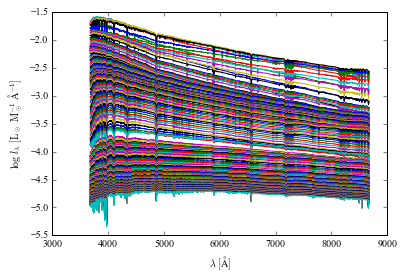

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

l = l_ssp[700:5700]
f = base_spec[700:5700]

for i, t in enumerate(age_base):
    plt.plot(l, np.log10(f[:, 0, i]))

plt.xlabel(r'$\lambda\ [\mathrm{\AA}]$')
plt.ylabel(r'$\log\ l_\lambda\ [\mathrm{L}_\odot\ \mathrm{M}_\odot^{-1}\ \mathrm{\AA}^{-1}]$')


This reshaping of the base may be coded into your base reading routine.

## Single stellar population properties

Spectral indices may be used to summarize a spectrum. Absorption line strenghts give a rough idea of the kinds of stellar populations you have. The $4000\,\unicode{xC5}$ break (which is not the Balmer jump!), is a very good tracer of the typical age of the stellar population. These can be (and are) used to study the stellar populations of galaxies, but we will perform full spectral analysis of the galaxies. Nevertheless, these indices should help one to have a better grasp of the spectral features of the spectra, and how they change with age (and metallicity). In addition to the $4000\,\unicode{xC5}$ break, or $D_n(4000)$, another widely used spectral index is $\mathrm{H}\delta_A$. For the base spectra, these are defined as follows:

$$
D_n(4000)_i = \frac{\int_{4000}^{4100} \lambda^2 l_\lambda(t_i)\,\mathrm{d}\lambda} {\int_{3850}^{3950} \lambda^2 l_\lambda(t_i)\,\mathrm{d}\lambda}.
$$

$$
\mathrm{H}\delta_{A,i} = \int_{4083}^{4122} \frac{c_\lambda - l_\lambda(t_i)} {c_\lambda}\,\mathrm{d}\lambda.
$$

The index $\mathrm{H}\delta_A$ is actually an equivalent width, measuring the strength of the absorption. The continuum $c_\lambda$ is calculated by linearly interpolating the line region ($4083.5 \to 4122.25\,\unicode{xC5}$) using two sidebands (the blue side at $4041.6 \to 4079.75$, and the red side at $4128.5 \to 4161\,\unicode{xC5}$).

Let's plot $\mathrm{H}\delta_A \times D_n(4000)$ for all base spectra.

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: divide by zero encountered in log10


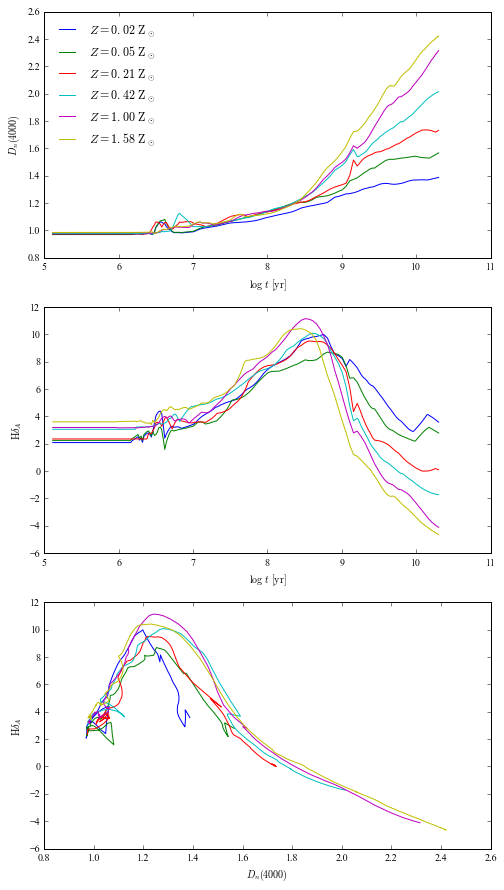

In [5]:
def Dn4000(l_ssp, f_ssp):
    blue_window = (l_ssp < 3950.0) & (l_ssp > 3850)
    red_window = (l_ssp < 4100.0) & (l_ssp > 4000)

    # The integrals below work because l_obs is crescent and the masks used in the fancy indexing are contiguous.
    l_ssp2 = (l_ssp**2)[:, np.newaxis, np.newaxis]
    flux_b = np.trapz(f_ssp[blue_window] * l_ssp2[blue_window], l_ssp[blue_window], axis=0)
    flux_r = np.trapz(f_ssp[red_window] * l_ssp2[red_window], l_ssp[red_window], axis=0)
    return flux_r / flux_b


def EW(l_ssp, f_ssp, l1, l2, lb1, lb2, lr1, lr2):
    line_mask = (l_ssp > l1) & (l_ssp < l2)
    blue_mask = (l_ssp > lb1) & (l_ssp < lb2)
    red_mask = (l_ssp > lr1) & (l_ssp < lr2)
    cont_b = f_ssp[blue_mask].mean(axis=0)
    cont_r = f_ssp[red_mask].mean(axis=0)
    lb = (lb1 + lb2) / 2
    lr = (lr1 + lr2) / 2
    l_ssp = l_ssp[line_mask, np.newaxis, np.newaxis]
    f_ssp = f_ssp[line_mask]

    alpha = (cont_r - cont_b) / (lr - lb)
    cont1 = cont_b + alpha * (l1 - lb)
    cont = cont1 + alpha * (l_ssp - l1)

    return np.trapz((cont - f_ssp) / cont, l_ssp, axis=0)


def Hd_A(l_ssp, f_ssp):
    return EW(l_ssp, f_ssp, 4083.500, 4122.250, 4041.600, 4079.750, 4128.500, 4161.000)

Hd_A_base = Hd_A(l_ssp, base_spec)
Dn4000_base = Dn4000(l_ssp, base_spec)

plt.figure(figsize=(8, 15))
plt.subplot(311)
for i, Z in enumerate(Z_base):
    plt.plot(np.log10(age_base), Dn4000_base[i], label=r'$Z = %.2f\ \mathrm{Z}_\odot$' % (Z / 0.019))
plt.xlabel(r'$\log\ t\ [\mathrm{yr}]$')
plt.ylabel(r'$D_n(4000)$')
plt.legend(loc='upper left', frameon=False)

plt.subplot(312)
for i, Z in enumerate(Z_base):
    plt.plot(np.log10(age_base), Hd_A_base[i], label=r'$Z = %.2f\ \mathrm{Z}_\odot$' % (Z / 0.019))
plt.xlabel(r'$\log\ t\ [\mathrm{yr}]$')
plt.ylabel(r'$\mathrm{H}\delta_A$')

plt.subplot(313)
for i, Z in enumerate(Z_base):
    plt.plot(Dn4000_base[i], Hd_A_base[i], label=r'$Z = %.2f\ \mathrm{Z}_\odot$' % (Z / 0.019))
plt.xlabel(r'$D_n(4000)$')
plt.ylabel(r'$\mathrm{H}\delta_A$')



The top figure shows that $D_n(4000)$ grows with the SSP age, while $\mathrm{H}\delta_A$, in the middle plot, increases and then decreases with age. The maximum occurs when the stars that have surface temperatures of $10^4\ \mathrm{K}$ dominate in luminosity. $D_n(4000)$ acts as a proxy for age, and allows us to know that, in the lower plot, the curve goes from left to right.

## Dust attenuation.

Dust eats the light and reprocesses it into far infrared wavelengths. Light gets scattered in and out of the line-of-sight. All these processes (an probably others I either forgot or don't know) are known as _attenuation_. We're gonna model the attenuation as a dust screen with an optical depth $\tau_\lambda$. The $\lambda$-dependence depends a lot on the micro-physics of the dust, which is not the point here. We will use an attenuation law such as CCM without questioning much.

Given a source of intrinsic flux $F_\lambda^\mathrm{int}$ and a dust screen of optical depth $\tau_\lambda$, the observed flux is

$$
F_\lambda^\mathrm{obs} = F_\lambda^\mathrm{int}\ \mathrm{e}^{-\tau_\lambda} = F_\lambda^\mathrm{int}\ \mathrm{e}^{-\tau_V q_\lambda}.
$$

The term $\tau_V$ measures the intensity of the attenuation, while the shape is given by $q_\lambda$. Roughly speaking, the attenuation hits stronger in the blue wavelengths, so that the spectra becomes redder. The CCM attenuation law is shown below. Note that there's also a "hunch" in the UV part of the attenuation.

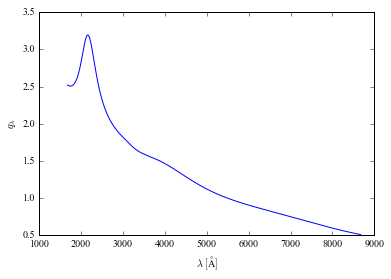

In [6]:
def q_CCM(l, R_V=3.1):
    a = np.zeros(np.shape(l))
    b = np.zeros(np.shape(l))
    F_a = np.zeros(np.shape(l))
    F_b = np.zeros(np.shape(l))
    x = np.zeros(np.shape(l))
    y = np.zeros(np.shape(l))
    q = np.zeros(np.shape(l))

    x = 10000. / l
    y = 10000. / l - 1.82

    # Far-Ultraviolet: 8 <= x <= 10 ; 1000 -> 1250 Angs 
    inter = np.bitwise_and(x >= 8, x <= 10)

    a[inter] = -1.073 - 0.628 * (x[inter] - 8.) + 0.137 * (x[inter] - 8.)**2 - 0.070 * (x[inter] - 8.)**3
    b[inter] = 13.670 + 4.257 * (x[inter] - 8.) - 0.420 * (x[inter] - 8.)**2 + 0.374 * (x[inter] - 8.)**3

    # Ultraviolet: 3.3 <= x <= 8 ; 1250 -> 3030 Angs 
    inter =  np.bitwise_and(x >= 5.9, x < 8)
    F_a[inter] = -0.04473 * (x[inter] - 5.9)**2 - 0.009779 * (x[inter] - 5.9)**3
    F_b[inter] =  0.2130 * (x[inter] - 5.9)**2 + 0.1207 * (x[inter] - 5.9)**3
    
    inter =  np.bitwise_and(x >= 3.3, x < 8)
    
    a[inter] =  1.752 - 0.316 * x[inter] - 0.104 / ((x[inter] - 4.67)**2 + 0.341) + F_a[inter]
    b[inter] = -3.090 + 1.825 * x[inter] + 1.206 / ((x[inter] - 4.62)**2 + 0.263) + F_b[inter]

    # Optical/NIR: 1.1 <= x <= 3.3 ; 3030 -> 9091 Angs ; 
    inter = np.bitwise_and(x >= 1.1, x < 3.3)
    
    a[inter] = 1.+ 0.17699 * y[inter] - 0.50447 * y[inter]**2 - 0.02427 * y[inter]**3 + \
        0.72085 * y[inter]**4 + 0.01979 * y[inter]**5 - 0.77530 * y[inter]**6 + 0.32999 * y[inter]**7
    b[inter] = 1.41338 * y[inter] + 2.28305 * y[inter]**2 + 1.07233 * y[inter]**3 - \
        5.38434 * y[inter]**4 - 0.62251 * y[inter]**5 + 5.30260 * y[inter]**6 - 2.09002 * y[inter]**7


    # Infrared: 0.3 <= x <= 1.1 ; 9091 -> 33333 Angs ; 
    inter = np.bitwise_and(x >= 0.3, x < 1.1)
    
    a[inter] =  0.574 * x[inter]**1.61
    b[inter] = -0.527 * x[inter]**1.61
    
    q = a + b / R_V

    return q


wave = l_ssp[200:5700]
plt.plot(wave, q_CCM(wave))
plt.xlabel(r'$\lambda\ [\mathrm{\AA}]$')
plt.ylabel(r'$q_\lambda$')


It is also instructive to see how it affects spectra. Taking a random model, let's plot the attenuaton for some values of $\tau_V$. (Model chosen by a fair dice roll, promise!)

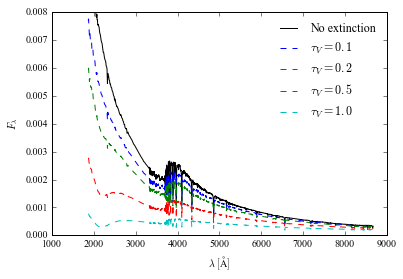

In [7]:
f_lambda = base_spec[220:5700, 0, 100]
l = l_ssp[220:5700]

q_lambda = q_CCM(l)
tau_V = [0.1, 0.2, 0.5, 1]

plt.plot(l, f_lambda, 'k-', label='No extinction')
for tV in tau_V:
    plt.plot(l, f_lambda * np.exp(-tV * q_lambda), ls='--', label=r'$\tau_V = %.1f$' % tV)
plt.ylim(0, 0.008)
plt.xlabel(r'$\lambda\ [\mathrm{\AA}]$')
plt.ylabel(r'$F_\lambda$')
plt.legend(frameon=False)



## Stellar kinematics

Stars move around. In a galaxy, the stars have a velocity distribution, which depends on the morphology, mass and what part you are looking at. This means that the spectral features will be broadened, and maybe shifted. This behavior is modeled (poorly) here as a Gaussian in velocity and a Doppler shift. That is

$$
L^\prime_\lambda = \int_{-\infty}^{+\infty} L\left(\lambda^\prime = \frac{\lambda}{1 + v/c}\right) \,G(v;v_\star,\sigma_\star)\,\mathrm{d}v
$$

Where $G(v;v_\star,\sigma_\star)$ is a Gaussian kernel centered at $v_\star$ with dispersion $\sigma_\star$. Numerically, one can resample the spectra into velocity bins (logarithmic steps in $
\lambda$) and perform the operation as a real convolution, which much faster using numpy. STARLIGHT does it in $\lambda$ space. Below is the code converted to Python, for reference. Keep in

(3800.0, 4100.0)

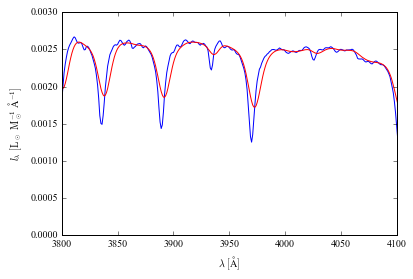

In [8]:
def gauss_velocity_smooth(lo, fo, v0, sig, ls=None, n_u=31, n_sig=6):
    c  = 2.997925e5
    if n_u < 5:
        raise ValueError('n_u=%d too small to integrate properly.' % n_u)
    if ls is None:
        ls = lo
    # Parameters for the brute-force integration in velocity
    u = np.linspace(-n_sig, n_sig, n_u)
    du = u[1] - u[0]
    d_lo = lo[1] - lo[0]
    Ns = len(ls)
    No = len(lo)
    fs = np.empty(Ns, dtype=fo.dtype)

    # loop over ls, convolving fo(lo) with a gaussian
    for i_s in xrange(Ns):
        # reset integral of {fo[ll = ls/(1+v/c)] * Gaussian} & start integration
        sum_fg = 0.
        for _u in u:
            # define velocity & lambda corresponding to u
            v  = v0 + sig * _u
            ll = ls[i_s] / (1.0 + v/c)
            # find fo flux for lambda = ll
            ind = int((ll - lo[0]) / d_lo)
            if ind < 0: 
                ff = fo[0]
            elif ind >= No-1:
                ff = fo[No-1]
            else:
                a  = (fo[ind+1] - fo[ind]) / (lo[ind+1] - lo[ind])
                b  = fo[ind] - a * lo[ind]
                ff = a * ll + b
            # smoothed spectrum
            sum_fg = sum_fg + ff * np.exp(-(_u**2/2.)) 
        fs[i_s] = sum_fg * du / np.sqrt(2. * np.pi)
    return fs


l = l_ssp[700:5700]
f = base_spec[700:5700, 0, 100]
v0 = 200.0
vd = 300.0
fs = gauss_velocity_smooth(l, f, v0, vd)

plt.plot(l, f, 'b-', label='original')
plt.plot(l, fs, 'r-', label='smoothed')

plt.xlabel(r'$\lambda\ [\mathrm{\AA}]$')
plt.ylabel(r'$l_\lambda\ [\mathrm{L}_\odot\ \mathrm{M}_\odot^{-1}\ \mathrm{\AA}^{-1}]$')
plt.xlim(3800.0, 4100.0)


The lines are shifted and broadened, keeping the fluxes the same. Note that the smoothed version has less information.

### Exercise

Convert the kinematics convolution code to velocity space.

## Composite stellar populations

Galaxies are not single SSPs. In general a galaxy has a star formation history (SFH), with a star formation rate (SFR) changing over time. This can be described by a function $\phi(t)$, such that the mass in stars formed between $t$ and $t+\mathrm{d}t$ is $\mathrm{d}M = \phi(t)\,\mathrm{d}t$. This mass in stars, today with age $t$, will have a luminosity $\mathrm{d}L_\lambda = l_\lambda(t)\,\phi(t)\,\mathrm{d}t$. The chemical composition is described by the single quantity $Z$, which is the metallicity. Then, integrating over the whole age of the Universe $T$, the total luminosity is

$$
L_\lambda = \int_0^T l_\lambda(t, Z)\, \phi(t, Z)\,\mathrm{d}t.
$$

We shall leave the metallicity aside for brevity, but it behaves the same as time in these models. Now, given an observed galaxy spectrum, one has only to find which function $\phi(t)$ that yields the $L_\lambda$ closest to the observed. The problem is, there's an infinite number of them.

A widely popular choice for $\phi(t)$ is an exponential decay starting at $t = t_0$.

$$
\phi(t) = \left\{
\begin{array}{ll}
A\,\exp\left( -\frac{t - t_0} {\tau}\right), & t \leq t_0\\
0, & t > t_0
\end{array}
\right.
$$

The time scale is dictated by $\tau$. Setting $\tau \to 0$ leads to a delta-function, that is, an SSP-like regime, while $\tau \to \infty$ leads to a constant SFR. The constant $A$ must be calculated so that the total amount of stellar mass $M_\star$ is formed.

At this point you should already have noted that we are talking about continuous functions, but the actual $l_\lambda(t)$ is in fact defined for dicrete values of $t$. The conversion from continous to discrete notation should be done with care. If the time scale $\tau$ is of the order of magnitude of the age sampling of the base, directly using the values of $\phi(t_i)$ may give the wrong results. In general, it is better to integrate $\phi(t)$ to find the amount of mass $\Delta M_i$ in each time bin $t_i$. This leads to

$$
L_\lambda = \sum_i l_\lambda(t_i)\,\Delta M_i.
$$

With attenuation, kinematics, and transforming from luminosity to flux, the equation becomes


$$
F_\lambda = \frac{1}{4\pi d^2}\sum_i l_\lambda(t_i)\,\Delta M_i\ \
\mathrm{e}^{-\tau_V q_\lambda} \otimes G(v; v_\star, \sigma_\star)
$$

where $d$ is the luminosity distance. This is a full spectral model, the problem now is, for an observed spectrum, find the modem which best fits the data.

### Exercise

1. Calculate the constant $A$ for the exponentially decaying SFH as a function of the total mass $M_\star$, $\tau$ and $t_0$.

2. Compute and plot CSP spectra for an exponentially decaying SFH. Explore the various combinations of $\tau$ and $t_0$, in special the cases where $\tau \ll t_0$ and $\tau \gg t_0$. For the same mass and $\tau$, how does the luminosity behave with varying $t_0$?

3. Bonus: Create a library of CSPs, with a grid of $\tau$, $t_0$ and dust attenuation $\tau_V$. Forget about the kinematics. Also forget about the mass, normalize models and data. Use spectral indices to see if the models are adequate. Choose some spaxel from the cube used last class (for example, the central one to minimize the effects of $v_0$), and search the models to see which is closer to it.